In [21]:
import os
import csv

import pandas as pd
import cv2
from tqdm import tqdm
import time

from boremeter.detector import detect_faces
from boremeter.bounding_boxes import have_intersection, bboxes_are_close
from boremeter.tracker import Tracker

In [32]:
class FaceRecognizer:
    def __init__(self, models_folder, caffe_model, prototype):
        model = os.path.join(models_folder, prototype)
        pretrained_weights = os.path.join(models_folder, caffe_model)

        self.net = caffe.Classifier(
            model,
            pretrained_weights,
            channel_swap=(2, 1, 0),
            raw_scale=255,
            image_dims=(256, 256),
        )

    def __del__(self):
        del self.net

    def predict(self, x):
        return self.net.predict(x, oversample=False)

    def reshape(self, batch_size):
        self.net.blobs['data'].reshape(batch_size,        # batch size
                                       3,                 # 3-channel (BGR) images
                                       224, 224)


class AgeRecognizer(FaceRecognizer):
    def predict(self, x):
        predictions = FaceRecognizer.predict(self, x)
        return [p.argmax() for p in predictions]


class GenderRecognizer(FaceRecognizer):
    def predict(self, x):
        genders = ['Female', 'Male']
        predictions = FaceRecognizer.predict(self, x)
        return [genders[p.argmax()] for p in predictions]

In [6]:
files = open('files.txt')

In [7]:
files = files.read().split('\n')

In [12]:
files = ['./2017_0204_122435_016-ds.MP4-crops/'+f for f in files]

In [14]:
files = pd.DataFrame(files)

In [19]:
files['age'] = np.zeros(len(files))

In [33]:
age_recognizer = AgeRecognizer(caffe_models_path, 'age.caffemodel', 'age.prototxt')
ages = {}

In [27]:
part = files.loc[:2000]

In [29]:
batch_sizes = [1, 10, 30, 50, 100, 500, 1000]

In [34]:
import pandas as pd
from tqdm import tqdm
import time
from boremeter.recognize_people import FaceRecognizer, AgeRecognizer, GenderRecognizer
files = open('2017_0204_122435_016-ds.MP4-crops-files.txt')
files = files.read().split('\n')
files = ['./2017_0204_122435_016-ds.MP4-crops/'+f for f in files]
files = pd.DataFrame(files)
files['age'] = np.zeros(len(files))
caffe_models_path = '/root/caffe/models/'
age_recognizer = AgeRecognizer(caffe_models_path, 'age.caffemodel', 'age.prototxt')
part = files.loc[:1000]
batch_sizes = [1, 10, 30, 50, 100, 500, 1000]

for batch_size in batch_sizes:
    print 'batch_size', batch_size
    start = time.time()
    for _, batch in tqdm(part.groupby(np.arange(len(part)) / batch_size)):
        images = []
        for i, face_row in batch.iterrows():
            input_image = caffe.io.load_image(files.loc[i][0])
            images.append(input_image)
        batch.loc[:, 'age'] = age_recognizer.predict(images)
    print time.time() - start

  0%|          | 0/67 [00:00<?, ?it/s]

batch_size 30


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
 22%|██▏       | 15/67 [16:03<54:13, 62.56s/it]  

KeyboardInterrupt: 

In [13]:
detected_faces = pd.read_csv('/Boremeter/all_extracted_faces.csv')
frames_limit = 200

In [20]:
detected_faces.loc[:, 'age'] = np.zeros(detected_faces.shape[0])
detected_faces.loc[:, 'gender'] = np.zeros(detected_faces.shape[0])
detected_faces.loc[:, 'interest'] = np.zeros(detected_faces.shape[0])

face_detector = cv2.CascadeClassifier(DETECTOR_CONFIG['VJ_cascade_path'])
    
for i, face_row in tqdm(detected_faces.iterrows(), total=detected_faces.shape[0]):
    if face_row['frame'] >= frames_limit:
        break

    detected_faces.loc[i, 'interest'] = np.random.randint(1, 100) > 50

interested_faces = detected_faces[detected_faces['interest'] == 1]

100%|██████████| 6230/6230 [00:03<00:00, 1725.68it/s]


In [26]:
recognition_step = 15

In [50]:
ages = {}

# recognize age if frame_id % recognition_step == 0

for i, face_row in tqdm(interested_faces.iterrows(), total=interested_faces.shape[0]):
    if face_row['frame'] > frames_limit:
        break
    if face_row['frame'] % recognition_step == 0:

        interested_faces.loc[i, 'age'] = np.random.randint(15, 80)

        if face_row['person_id'] in ages:
            ages[face_row['person_id']][0] += face_row['age']
            ages[face_row['person_id']][1] += 1
        else:
            ages[face_row['person_id']] = [face_row['age'], 1]
                

100%|██████████| 3075/3075 [00:12<00:00, 255.21it/s]


In [54]:
interested_faces[interested_faces['frame'] == 30]

,Unnamed: 0,frame,person_id,x,y,w,h,age,gender,interest
765,765,30.0,1.0,1355.538916,957.168762,111.042008,155.213011,71.0,0.0,True
766,766,30.0,2.0,438.958691,649.788591,27.100667,39.726717,33.0,0.0,True
768,768,30.0,4.0,799.457476,931.303065,103.933772,166.092337,45.0,0.0,True
771,771,30.0,7.0,551.326774,621.800915,31.789441,44.812329,74.0,0.0,True
775,775,30.0,11.0,930.511243,763.371699,45.959001,60.035106,20.0,0.0,True
776,776,30.0,12.0,1401.297518,507.183920,32.452603,44.362658,49.0,0.0,True
779,779,30.0,15.0,2013.015470,501.182986,34.840762,43.602773,15.0,0.0,True
781,781,30.0,17.0,348.807949,681.174805,26.262718,37.167388,52.0,0.0,True
783,783,30.0,19.0,300.925471,900.071538,30.405938,38.459394,46.0,0.0,True
785,785,30.0,21.0,2372.186743,718.103989,42.895557,65.013457,32.0,0.0,True


In [38]:
for i, face_row in detected_faces.iterrows():
    try:
        ages_sum, count = ages[face_row['person_id']]
        detected_faces.loc[i, 'age'] = ages_sum / count

    except KeyError:
        detected_faces.drop(i, inplace=True)  # mean? median?

In [55]:
['Male', 'Female'][np.random.randint(0, 2)]

'Female'

In [58]:
genders = {}

for i, face_row in tqdm(interested_faces.iterrows(), total=interested_faces.shape[0]):
    if face_row['frame'] > frames_limit:
        break
    if face_row['frame'] % recognition_step == 0:

        face_row['gender'] = ['Male', 'Female'][np.random.randint(0, 2)]
        print face_row['gender'],
        if face_row['person_id'] in genders:
            genders[face_row['person_id']][0] += int(face_row['gender'] == 'Male')
            genders[face_row['person_id']][1] += 1
        else:
            genders[face_row['person_id']] = [int(face_row['gender'] == 'Male'), 1]

 21%|██▏       | 659/3075 [00:00<00:00, 6589.35it/s]

Male Male Male Female Female Male Female Female Female Male Male Female Female Female Male Male Female Female Male Male Male Female Male Male Female Female Female Male Male Female Female Female Female Female Female Male Male Female Female Female Male Female Male Female Male Female Female Female Female Female Female Male Female Female Male Female Male Female Male Female Female Female Male Male Female Female Male Female Male Female Female Male Female Female Male Female Male Male Male Male Male Male Male Female Male Female Female Female Male Female Male Female Female Female Male Female Male Female Male Male Female Female Male Female Male Female Male Male

100%|██████████| 3075/3075 [00:00<00:00, 7785.40it/s]

 Male Female Male Male Female Female Female Female Female Female Male Male Female Female Male Female Female Female Female Male Male Male Male Female Female Female Female Male Female Female Female Female Female Female Female Male Male Female Female Male Female Male Male Female Female Female Male Female Female Female Female Female Female Female Female Male Male Male Female Female Female Male Female Male Male Female Male Male Male Male Female Male Female Female Female Male Male Male Male Male Female Female Male Female Female Female Female Female Female Male Male Female Female Male Male Male Female Female Male Male Male Female Female Male Male Male Female Male Male Female Female Male


In [62]:
for i, face_row in detected_faces.iterrows():
        try:
            detected_faces.loc[i, 'gender'] = 'Male' if (float(genders[face_row['person_id']][0]) /
                                                         genders[face_row['person_id']][1]) > 0.5 else 'Female'
        except KeyError:
            detected_faces.drop(i, inplace=True)

In [63]:
detected_faces

,Unnamed: 0,frame,person_id,x,y,w,h,age,gender,interest
0,0,0.0,1.0,1363.596558,969.311315,112.896991,150.526156,42.333333,Male,False
1,1,0.0,2.0,440.469945,651.432828,27.159737,36.312399,50.666667,Female,True
2,2,0.0,3.0,2143.777585,823.650327,99.352328,145.549211,45.000000,Male,False
3,3,0.0,4.0,799.500235,924.315427,107.416052,172.983056,56.166667,Female,False
4,4,0.0,5.0,979.818037,822.530515,86.364428,116.735330,48.833333,Male,False
5,5,0.0,6.0,1255.916110,711.559723,63.315006,81.471934,32.857143,Female,True
6,6,0.0,7.0,551.324917,622.384538,31.847501,44.697914,51.333333,Female,True
7,7,0.0,8.0,1839.129574,738.318835,69.076979,95.025975,41.888889,Female,True
8,8,0.0,9.0,1488.958360,837.897040,135.229318,186.729248,28.500000,Female,False
9,9,0.0,10.0,1457.164924,705.897175,41.335798,56.646182,54.444444,Female,True


In [75]:
def recognize_faces(detected_faces):

    # read table of detected people
    # populate age, gender and interest with zeros for the moment

    # detected_faces = pd.read_csv(os.path.join(tmp_dir, 'faces.csv'))
    detected_faces.loc[:, 'age'] = np.zeros(detected_faces.shape[0])
    detected_faces.loc[:, 'gender'] = np.zeros(detected_faces.shape[0])
    detected_faces.loc[:, 'interest'] = np.zeros(detected_faces.shape[0])
    
    for i, face_row in tqdm(detected_faces.iterrows(), total=detected_faces.shape[0]):
        if face_row['frame'] >= frames_limit:
            break

        detected_faces.loc[i, 'interest'] = np.random.randint(0, 2)

    interested_faces = detected_faces[detected_faces['interest'] == 1]
    ages = {}

    # recognize age if frame_id % recognition_step == 0

    for i, face_row in tqdm(interested_faces.iterrows(), total=interested_faces.shape[0]):
        if face_row['frame'] > frames_limit:
            break
        if face_row['frame'] % recognition_step == 0:

            face_row['age'] = np.random.randint(10, 90)

            if face_row['person_id'] in ages:
                ages[face_row['person_id']][0] += face_row['age']
                ages[face_row['person_id']][1] += 1
            else:
                ages[face_row['person_id']] = [face_row['age'], 1]

    for i, face_row in detected_faces.iterrows():

        try:
            ages_sum, count = ages[face_row['person_id']]
            detected_faces.loc[i, 'age'] = ages_sum / count

        except KeyError:
            detected_faces.drop(i, inplace=True)  # mean? median?

    # recognize gender if frame_id % recognition_step == 0

    genders = {}

    for i, face_row in tqdm(interested_faces.iterrows(), total=interested_faces.shape[0]):
        if face_row['frame'] > frames_limit:
            break
        if face_row['frame'] % recognition_step == 0:

            face_row['gender'] = ['Male', 'Female'][np.random.randint(0, 2)]
            if face_row['person_id'] in genders:
                genders[face_row['person_id']][0] += int(face_row['gender'] == 'Male')
                genders[face_row['person_id']][1] += 1
            else:
                genders[face_row['person_id']] = [int(face_row['gender'] == 'Male'), 1]
                

    for i, face_row in detected_faces.iterrows():

        try:
            detected_faces.loc[i, 'gender'] = 'Male' if (float(genders[face_row['person_id']][0]) /
                                                         genders[face_row['person_id']][1]) > 0.5 else 'Female'
        except KeyError:
            detected_faces.drop(i, inplace=True)

    return detected_faces, ages, genders

In [76]:
faces, ages, genders = recognize_faces(detected_faces)

100%|██████████| 2955/2955 [00:00<00:00, 15744.62it/s]


In [77]:
faces

,Unnamed: 0,frame,person_id,x,y,w,h,age,gender,interest
0,0,0.0,1.0,1363.596558,969.311315,112.896991,150.526156,40.125000,Male,0.0
1,1,0.0,2.0,440.469945,651.432828,27.159737,36.312399,59.200000,Female,1.0
2,2,0.0,3.0,2143.777585,823.650327,99.352328,145.549211,62.166667,Female,1.0
3,3,0.0,4.0,799.500235,924.315427,107.416052,172.983056,55.000000,Male,1.0
4,4,0.0,5.0,979.818037,822.530515,86.364428,116.735330,46.800000,Male,0.0
5,5,0.0,6.0,1255.916110,711.559723,63.315006,81.471934,58.800000,Female,0.0
6,6,0.0,7.0,551.324917,622.384538,31.847501,44.697914,65.000000,Male,1.0
7,7,0.0,8.0,1839.129574,738.318835,69.076979,95.025975,62.111111,Male,1.0
8,8,0.0,9.0,1488.958360,837.897040,135.229318,186.729248,31.714286,Male,1.0
9,9,0.0,10.0,1457.164924,705.897175,41.335798,56.646182,68.333333,Male,0.0


In [91]:
def recognize_faces(detected_faces, batch_size=30):

    # read table of detected people
    # populate age, gender and interest with zeros for the moment

    # detected_faces = pd.read_csv(os.path.join(tmp_dir, 'faces.csv'))
    detected_faces.loc[:, 'age'] = np.zeros(detected_faces.shape[0])
    detected_faces.loc[:, 'gender'] = np.zeros(detected_faces.shape[0])
    detected_faces.loc[:, 'interest'] = np.zeros(detected_faces.shape[0])

    # recognize interested faces

    for i, face_row in tqdm(detected_faces.iterrows(), total=detected_faces.shape[0]):
        if face_row['frame'] >= frames_limit:
            break

        detected_faces.loc[i, 'interest'] = np.random.randint(0,2)

    # recognize age if frame_id % recognition_step == 0 and only on interested faces

    interested_faces = detected_faces[detected_faces['interest'] == 1]
    interested_faces = interested_faces[interested_faces['frame'] % recognition_step == 0]

    # load pre-trained nets
    ages = {}

    for _, batch in tqdm(interested_faces.groupby(np.arange(len(interested_faces)) / batch_size)):
        batch.loc[:, 'age'] = np.random.randint(0, 100, batch.shape[0])
        for i, face_row in batch.iterrows():
            if face_row['person_id'] in ages:
                ages[face_row['person_id']][0] += face_row['age']
                ages[face_row['person_id']][1] += 1
            else:
                ages[face_row['person_id']] = [face_row['age'], 1]

    for i, face_row in detected_faces.iterrows():
        try:
            ages_sum, count = ages[face_row['person_id']]
            detected_faces.loc[i, 'age'] = ages_sum / count

        except KeyError:
            detected_faces.drop(i, inplace=True) # mean? median? maybe we should delete faces that appear on very few frames?

    # recognize gender if frame_id % recognition_step == 0

    genders = {}

    for _, batch in tqdm(interested_faces.groupby(np.arange(len(interested_faces)) / batch_size)):
        print _
        batch.loc[:, 'gender'] = [['Male', 'Female'][np.random.randint(0, 2)] for _ in range(batch.shape[0])]
        for i, face_row in batch.iterrows():
            if face_row['person_id'] in genders:
                genders[face_row['person_id']][0] += int(face_row['gender'] == 'Male')
                genders[face_row['person_id']][1] += 1
            else:
                genders[face_row['person_id']] = [int(face_row['gender'] == 'Male'), 1]

    for i, face_row in detected_faces.iterrows():
        try:
            detected_faces.loc[i, 'gender'] = 'Male' if (float(genders[face_row['person_id']][0]) /
                                                         genders[face_row['person_id']][1]) > 0.5 else 'Female'
        except KeyError:
            detected_faces.drop(i, inplace=True)

    return detected_faces, ages, genders

In [92]:
faces, ages, genders = recognize_faces(detected_faces)

 57%|█████▋    | 4/7 [00:00<00:00, 17.11it/s]

0
1
2
3


100%|██████████| 7/7 [00:00<00:00, 16.93it/s]


4
5
6


In [144]:
class FaceRecognizer:
    def __init__(self, models_folder, caffe_model, prototype):
        model = os.path.join(models_folder, prototype)
        pretrained_weights = os.path.join(models_folder, caffe_model)

        self.net = caffe.Classifier(
            model,
            pretrained_weights,
            channel_swap=(2, 1, 0),
            raw_scale=255,
            image_dims=(256, 256),
        )

    def __del__(self):
        del self.net

    def predict(self, x):
        return self.net.predict(x, oversample=False)

    def reshape(self, batch_size):
        self.net.blobs['data'].reshape(batch_size,        # batch size
                                       3,                 # 3-channel (BGR) images
                                       224, 224)


class AgeRecognizer(FaceRecognizer):
    def predict(self, x):
        predictions = FaceRecognizer.predict(self, x)
        return [p.argmax() for p in predictions]


class GenderRecognizer(FaceRecognizer):
    def predict(self, x):
        genders = ['Female', 'Male']
        predictions = FaceRecognizer.predict(self, x)
        return [genders[p.argmax()] for p in predictions]

In [23]:
caffe_models_path = '/root/caffe/models/'

In [135]:
age_recognizer = AgeRecognizer(caffe_models_path, 'age.caffemodel', 'age.prototxt')

In [136]:
age_recognizer.reshape(2)

In [137]:
img1 = caffe.io.load_image('person1frame1.jpg')
img2 = caffe.io.load_image('person1frame20.jpg')

In [138]:
age_recognizer.predict(imgs)

[23, 24]

In [99]:
imgs = [img1, img2]

In [148]:
gender_recognizer = GenderRecognizer(caffe_models_path, 'gender.caffemodel', 'gender.prototxt')

In [146]:
gender_recognizer.reshape(2)

In [149]:
gender_recognizer.predict(imgs)

['Male', 'Male']

In [121]:
model = os.path.join(caffe_models_path, 'age.prototxt')
pretrained_weights = os.path.join(caffe_models_path, 'age.caffemodel')

net = caffe.Classifier(
            model,
            pretrained_weights,
            channel_swap=(2, 1, 0),
            raw_scale=255,
            image_dims=(256, 256),
            )

In [125]:
list(net.blobs['data'].shape)

[1, 3, 224, 224]

In [106]:
pred = net.predict(imgs, oversample=False)

24

In [111]:
pred[0].argmax(), pred[1].argmax()

(23, 24)

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

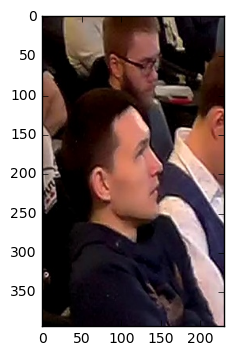

In [110]:
plt.imshow(img1)

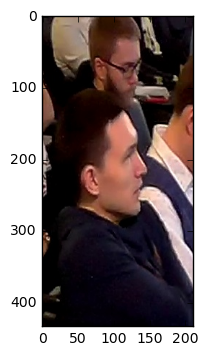

In [112]:
plt.imshow(img2)